# Figure 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import LSQUnivariateSpline

datapath = '../Processed_data/Nino3_4_DJF/'
#experiments = ['piControl', 'historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']
experiments = ['piControl', 'ssp126', 'ssp245', 'ssp370', 'ssp585']
models = ['BCC-CSM2-MR', 'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'E3SM-1-0', 
          'EC-Earth3', 'EC-Earth3-Veg', 'MIROC-ES2L', 'MIROC6', 'HadGEM3-GC31-LL',
           'HadGEM3-GC31-MM', 'UKESM1-0-LL', 'MRI-ESM2-0', 'GISS-E2-1-G', 'CESM2',
           'CESM2-WACCM', 'SAM0-UNICON', 'MCM-UA-1-0'] # , 'GFDL-ESM4'

historical_required_length = 165 - 1; # subtract 1 because of missing value first year
ssp_required_length = 86;
piControl_min_length = 496 - 1; # main member, that we use to compute errorbars.
piControl_min_length_other_members = 100; # used only for computing a mean value, so we don't require the same length

# create empty dataframe that will later be filled with values
cols = [('piControl', 'length'), ('piControl' ,'length of other members'), ('historical', 'members'), ('ssp126', 'members'), ('ssp245', 'members'), ('ssp370', 'members'), ('ssp585', 'members')]
df = pd.DataFrame(index = models, columns = cols)


In [2]:
def choose_member(datatable, exp, model):
    if exp == 'historical':
        required_length = historical_required_length; 
    elif exp in experiments[-4:]: # if future scenario
        required_length = ssp_required_length;
    elif exp == 'piControl':
        required_length = piControl_min_length;
    
    member_priority_list = ['r1i1p1f1', 'r1i1p1f2', 'r1i1p1f3', 'r2i1p1f2', 'r22i1p1f1', 'r2i1p1f1']
    chosen_member = None
    for member in member_priority_list:
        if member in datatable[exp]:
            data = np.array([np.float(i) for i in datatable[exp][member].values if i])
            #print(len(data))
            if len(data) >= required_length:
                chosen_member = member
                break
    if chosen_member == None:
        print('failed for', exp, model, ' - add more members to priority list')
    return chosen_member
    
# find ensemble members that exist for all experiments:
def common_member(datatable):
    model_exp = list(set([exp[0] for exp in data_table.columns]))
    exp_members = {}
    for exp in model_exp:
        exp_members[exp] = set([member for member in data_table[exp].columns])
    common_members = set.intersection(*exp_members.values())
    return common_members



## List common ensemble members across experiments:

In [3]:
for (k,model) in enumerate(models):
    file = model + '_DJF_nino3_4index.txt'
    data_table = pd.read_csv(datapath + file,index_col=0, header=[0,1], keep_default_na = False)
    print(model, common_member(data_table))

BCC-CSM2-MR {'r1i1p1f1'}
CanESM5 {'r1i1p2f1', 'r1i1p1f1'}
CNRM-CM6-1 {'r1i1p1f2'}
CNRM-ESM2-1 set()
E3SM-1-0 {'r1i1p1f1'}
EC-Earth3 set()
EC-Earth3-Veg {'r1i1p1f1'}
MIROC-ES2L {'r1i1p1f2'}
MIROC6 {'r1i1p1f1'}
HadGEM3-GC31-LL set()
HadGEM3-GC31-MM {'r1i1p1f1'}
UKESM1-0-LL {'r1i1p1f2'}
MRI-ESM2-0 {'r1i1p1f1'}
GISS-E2-1-G {'r101i1p1f1', 'r1i1p1f1', 'r1i1p1f2', 'r102i1p1f1', 'r2i1p1f1'}
CESM2 {'r1i1p1f1'}
CESM2-WACCM {'r1i1p1f1'}
SAM0-UNICON {'r1i1p1f1'}
MCM-UA-1-0 set()


In [4]:
# define x-coordiates and colors for each experiment
x = {}
colors = ['black', 'blue', 'purple', 'red', 'green', 'cyan']
color_dict = {}
delta_x = 0.1
for ind,exp in enumerate(experiments):
    x[exp] = np.arange(len(models)) + 1 + delta_x*ind
    color_dict[exp] = colors[ind]

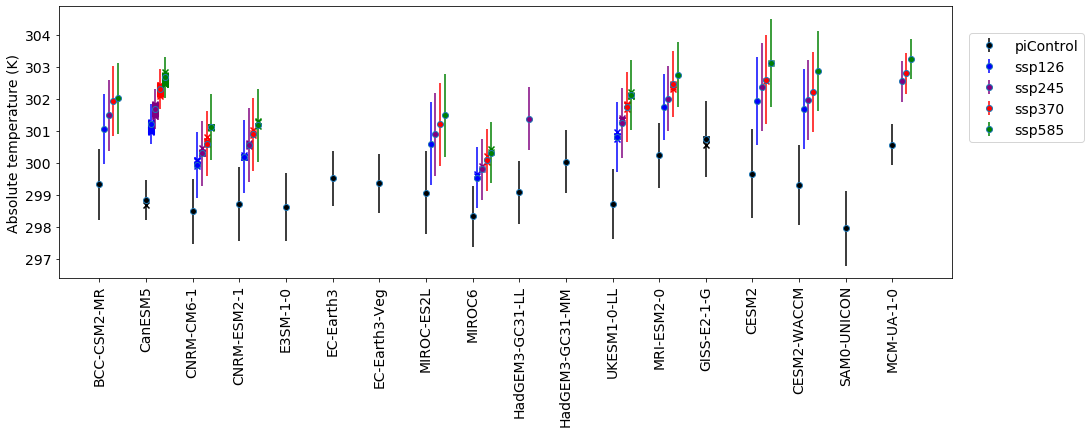

In [5]:
# create figure:
fig, ax = plt.subplots(figsize = [16,5])

for (k,model) in enumerate(models):
    file = model + '_DJF_nino3_4index.txt'
    data_table = pd.read_csv(datapath + file,index_col=0, header=[0,1], keep_default_na = False)
    members = {}
    for exp in experiments:
        members[exp] = 0
        if exp in data_table:
            plot_member = choose_member(data_table, exp, model)
            
            # plot other members first
            other_members = [member for member in data_table[exp] if member != plot_member]
            piControl_lengths = []
            for member in other_members:
                data_list = data_table[exp][member].values
                data = np.array([np.float(i) for i in data_list if i])
                if exp in experiments[-4:]: # if future scenario
                    if len(data) >= ssp_required_length:
                        data = data[:ssp_required_length] # stop in year 2100, and plot only data going to 2100
                        ax.scatter(x[exp][k], data.mean(), marker = 'x', color=color_dict[exp])
                        members[exp] += 1
                elif exp == 'historical':
                    if len(data) >= historical_required_length:
                        ax.scatter(x[exp][k], data.mean(), marker = 'x', color=color_dict[exp])
                        members[exp] += 1
                elif exp == 'piControl': 
                    if len(data) >= piControl_min_length_other_members:
                        ax.scatter(x[exp][k], data.mean(), marker = 'x', color=color_dict[exp])
                        members[exp] += 1
                        piControl_lengths.append(str(len(data) + 1))
                        
            # plot chosen member with error bars from piControl std
            data_list = data_table[exp][plot_member].values
            # remove empty strings and convert remaining strings to float:
            data = np.array([np.float(i) for i in data_list if i])
            if exp in experiments[-4:]: # if future scenario
                data = data[:ssp_required_length] # stop in year 2100
            if exp == 'piControl':
                control_data = data
                df.loc[model][('piControl', 'length')] = len(control_data) + 1 # to give original length
                df.loc[model][('piControl', 'length of other members')] = ",".join(piControl_lengths)
            if k == 0:
                # define also labels for legend
                ax.errorbar(x[exp][k], data.mean(), yerr=control_data.std(), fmt='o', ecolor=color_dict[exp], mfc=color_dict[exp], label = exp)
                members[exp] += 1
            else:
                ax.errorbar(x[exp][k], data.mean(), yerr=control_data.std(), fmt='o', ecolor=color_dict[exp], mfc=color_dict[exp])
                members[exp] += 1
        # save number of members in dataframe
        if exp in experiments[1:]:
            df.loc[model][(exp, 'members')] = members[exp]
    
ax.tick_params(axis='both',labelsize=14)    
ax.set_ylabel('Absolute temperature (K)', fontsize = 14)
plt.xticks(x['piControl'], models, rotation=90);
ax.legend(loc=(1.02,0.5), fontsize = 14);

#plt.savefig('../Figures/Figure1_absolute.png', format='png', dpi=300, bbox_inches="tight")

BCC-CSM2-MR r1i1p1f1 piControl
BCC-CSM2-MR r1i1p1f1 ssp126
BCC-CSM2-MR r1i1p1f1 ssp245
BCC-CSM2-MR r1i1p1f1 ssp370
BCC-CSM2-MR r1i1p1f1 ssp585
CanESM5 r1i1p1f1 piControl
CanESM5 r1i1p1f1 ssp126
CanESM5 r1i1p1f1 ssp245
CanESM5 r1i1p1f1 ssp370
CanESM5 r1i1p1f1 ssp585
CNRM-CM6-1 r1i1p1f2 piControl
CNRM-CM6-1 r1i1p1f2 ssp126
CNRM-CM6-1 r1i1p1f2 ssp245
CNRM-CM6-1 r1i1p1f2 ssp370
CNRM-CM6-1 r1i1p1f2 ssp585
CNRM-ESM2-1 r1i1p1f2 piControl
CNRM-ESM2-1 r1i1p1f2 ssp126
CNRM-ESM2-1 r1i1p1f2 ssp245
CNRM-ESM2-1 r2i1p1f2 ssp370
CNRM-ESM2-1 r2i1p1f2 ssp585
E3SM-1-0 r1i1p1f1 piControl
EC-Earth3 r1i1p1f1 piControl
EC-Earth3-Veg r1i1p1f1 piControl
MIROC-ES2L r1i1p1f2 piControl
MIROC-ES2L r1i1p1f2 ssp126
MIROC-ES2L r1i1p1f2 ssp245
MIROC-ES2L r1i1p1f2 ssp370
MIROC-ES2L r1i1p1f2 ssp585
MIROC6 r1i1p1f1 piControl
MIROC6 r1i1p1f1 ssp126
MIROC6 r1i1p1f1 ssp245
MIROC6 r1i1p1f1 ssp370
MIROC6 r1i1p1f1 ssp585
HadGEM3-GC31-LL r1i1p1f1 piControl
HadGEM3-GC31-LL r1i1p1f3 ssp245
HadGEM3-GC31-MM r1i1p1f1 piControl
UKESM

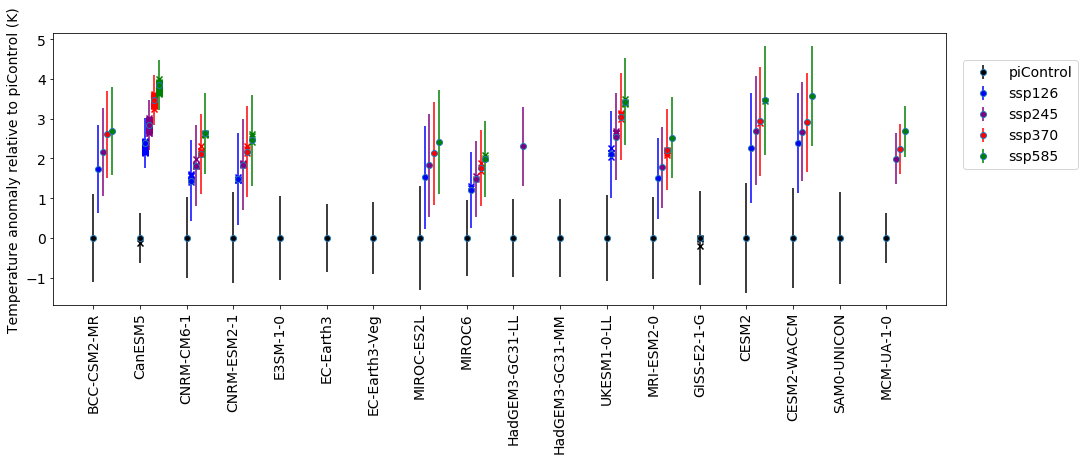

In [6]:
# create figure:
fig, ax = plt.subplots(figsize = [16,5])

for (k,model) in enumerate(models):
    file = model + '_DJF_nino3_4index.txt'
    data_table = pd.read_csv(datapath + file,index_col=0, header=[0,1], keep_default_na = False)
    
    for exp in experiments:
        if exp in data_table:
            plot_member = choose_member(data_table, exp, model)
                
            print(model,plot_member, exp)
            data_list = data_table[exp][plot_member].values
            # remove empty strings and convert remaining strings to float:
            data = np.array([np.float(i) for i in data_list if i])
            
            if exp in experiments[-4:]: # if future scenario
                data = data[:ssp_required_length] # stop in year 2100

            if exp == 'piControl':
                control_data = data
            if k == 0:
                # define labels for legend
                ax.errorbar(x[exp][k], data.mean() - control_data.mean(), yerr=control_data.std(), fmt='o', ecolor=color_dict[exp], mfc=color_dict[exp], label = exp)
            else:
                ax.errorbar(x[exp][k], data.mean() - control_data.mean(), yerr=control_data.std(), fmt='o', ecolor=color_dict[exp], mfc=color_dict[exp])
                        
            # plot other members
            other_members = [member for member in data_table[exp] if member != plot_member]
            for member in other_members:
                data_list = data_table[exp][member].values
                data = np.array([np.float(i) for i in data_list if i])
                if exp in experiments[-4:]: # if future scenario
                    if len(data) >= ssp_required_length:
                        data = data[:ssp_required_length] # stop in year 2100, and plot only data going to 2100
                        ax.scatter(x[exp][k], data.mean() - control_data.mean(), marker = 'x', color=color_dict[exp])
                elif exp == 'historical':
                    if len(data) >= historical_required_length:
                        ax.scatter(x[exp][k], data.mean() - control_data.mean(), marker = 'x', color=color_dict[exp])
                elif exp == 'piControl':
                    if len(data) >= piControl_min_length_other_members:
                        ax.scatter(x[exp][k], data.mean() - control_data.mean(), marker = 'x', color=color_dict[exp])
ax.tick_params(axis='both',labelsize=14)
ax.set_ylabel('Temperature anomaly relative to piControl (K)', fontsize = 14)
plt.xticks(x['piControl'], models, rotation=90);
ax.legend(loc=(1.02,0.5), fontsize = 14);

#plt.savefig('../Figures/Figure1_anomalies.png', format='png', dpi=300, bbox_inches="tight")

## Update figure to also include a panel of variances:

 in addition, we choose members consistent with the single member analyses

In [7]:
def choose_member(datatable, exp, model):
    if exp == 'historical':
        required_length = historical_required_length; 
    elif exp in experiments[-4:]: # if future scenario
        required_length = ssp_required_length;
    elif exp == 'piControl':
        required_length = piControl_min_length;
        
    # for the models in this if-test, previous tests have shown that they are long enough,
    # so we don't have to test for that
    # this test is the same as used for single member analyses
    if model in ['BCC-CSM2-MR', 'CanESM5', 'MIROC6', 'MRI-ESM2-0',  'CESM2', 'CESM2-WACCM']:
            chosen_member = 'r1i1p1f1'
    elif model in ['MIROC-ES2L', 'CNRM-CM6-1','MCM-UA-1-0', 'UKESM1-0-LL']:
        if exp == 'piControl' and model == 'MCM-UA-1-0':
            chosen_member = 'r1i1p1f1'
        else:
            chosen_member = 'r1i1p1f2' # I have checked that historical f2 branches from piControl f1 in MCM-UA-1-0.     
    elif model in ['CNRM-ESM2-1']:
        if exp == 'piControl':
            chosen_member = 'r1i1p1f2'
        else: 
            chosen_member = 'r2i1p1f2'    
    else: # for all other models:
        member_priority_list = ['r1i1p1f1', 'r1i1p1f2', 'r1i1p1f3', 'r2i1p1f2', 'r22i1p1f1', 'r2i1p1f1']
        chosen_member = None
        for member in member_priority_list:
            if member in datatable[exp]:
                data = np.array([np.float(i) for i in datatable[exp][member].values if i])
                #print(len(data))
                if len(data) >= required_length:
                    chosen_member = member
                    break
    if chosen_member == None:
        print('failed for', exp, model, ' - add more members to priority list')
    return chosen_member

# parent experiment checks for models where different variant labels are used:
# E3SM-1-0 r2i1p1f1 historical braches from piControl r1i1p1f1 (and historical r1 is missing years)
# EC-Earth3 r22i1p1f1 historical has no parent???
# HadGEM3-GC31-LL r1i1p1f3 historical braches from piControl r1i1p1f1 


def find_anomaly(model, exp, data = None):
    if model in ['BCC-CSM2-MR', 'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'MIROC-ES2L', 
              'MIROC6', 'UKESM1-0-LL', 'MRI-ESM2-0',  'CESM2', 'CESM2-WACCM', 'MCM-UA-1-0']:
        # use anomalies computed for single member analyses
        file = 'detrended_single_members.txt'
        data_table = pd.read_csv(datapath + file, index_col=0, header=[0,1], keep_default_na = False)
        data_list = data_table[model][exp].values
        anomalies = np.array([np.float(i) for i in data_list if i])  
    elif model == 'HadGEM3-GC31-LL' and exp in ['historical', 'ssp245']:
        # data from both experiments should be loaded, so read data directly from file
        # data are combined before computing trend, just like for the models above
        file = model + '_DJF_nino3_4index.txt'
        data_table = pd.read_csv(datapath + file,index_col=0, header=[0,1], keep_default_na = False)
        hist_data = np.array([np.float(i) for i in data_table['historical']['r1i1p1f3'].values if i]) 
        ssp_data = np.array([np.float(i) for i in data_table['ssp245']['r1i1p1f3'].values if i]) 
        all_data = np.concatenate((hist_data, ssp_data))
        all_years = np.arange(1851, 2101);
        
        internal_knots = [1850 + (2014-1850)/2, 2014]
        spl = LSQUnivariateSpline(all_years, all_data, internal_knots)
        if exp == 'historical':
            hist_trend = spl(np.arange(1851, 2015))
            anomalies = hist_data - hist_trend
        elif exp == 'ssp245':
            ssp_trend = spl(np.arange(2015, 2101))
            anomalies = ssp_data - ssp_trend
    else:
        # compute new anomalies (but end of historical trend will be more uncertain when lacking ssp scenarios)
        # requires that data is an input
        if exp == 'historical':
            exp_years = np.arange(1851, 2015) # no DJF mean in 1850
            spl = LSQUnivariateSpline(exp_years, data, [1850 + (2014-1850)/2])
            trend = spl(exp_years)
            anomalies = data - trend
        elif exp == 'piControl':
            # subtract linear trend
            p = np.polyfit(np.arange(len(data)), data, deg = 1)
            trend = np.polyval(p,np.arange(len(data)))
            anomalies = data - trend
    return anomalies
    
def segments(data, years_used = 500, seg_length = 86, seg_overlap = 40):
    x = data[:years_used]
    starttimes = np.arange(0,len(x)-seg_length+1,seg_length - seg_overlap)
    segment_list = np.full((len(starttimes), seg_length), np.nan)
    
    for (i,k) in enumerate(starttimes):
        segment = x[int(k):int(k)+seg_length]; 
        segment_list[i] = segment
        
    segment_means = np.array([segment_list[i,:].mean() for i in range(len(starttimes))])
    segment_variances = np.array([segment_list[i,:].var() for i in range(len(starttimes))])
        
    return segment_means, segment_variances



In [8]:
# define x-coordiates and colors for each experiment
x = {}
#colors = ['black', 'blue', 'purple', 'red', 'green', 'cyan']
colors = ['black', 'blue', 'purple', 'red', 'green']
color_dict = {}
delta_x = 0.1
for ind,exp in enumerate(experiments):
    x[exp] = np.arange(len(models)) + 1 + delta_x*ind
    color_dict[exp] = colors[ind]

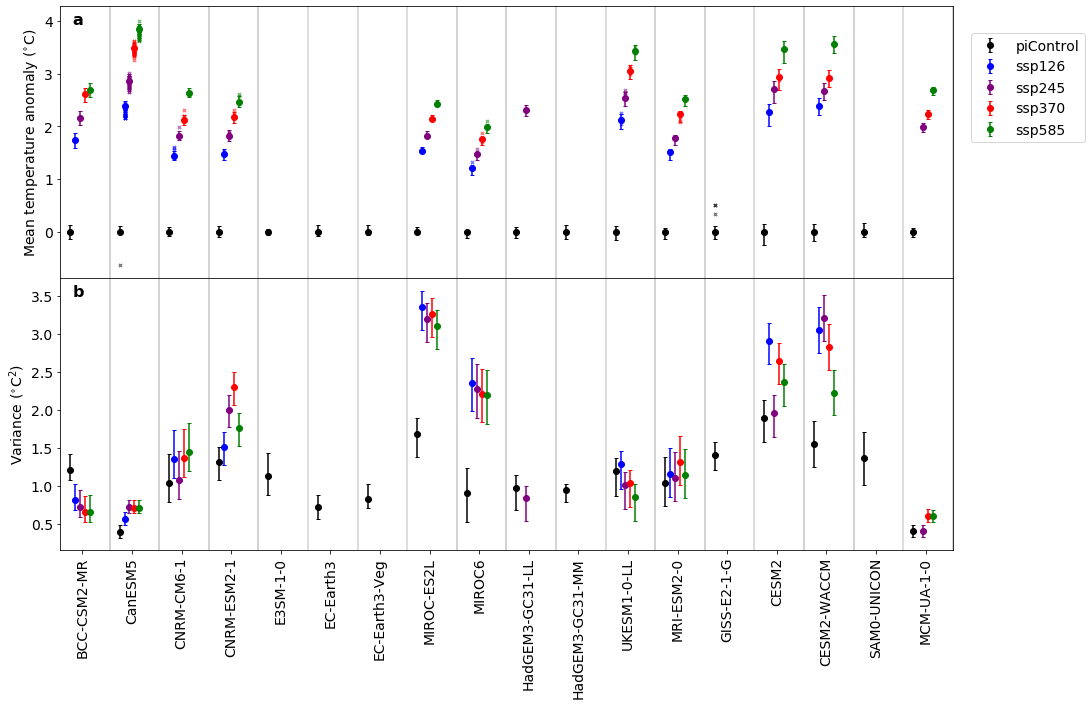

In [9]:
# create figure:
fig, ax = plt.subplots(nrows = 2, figsize = [16,10])
#fig, ax = plt.subplots(nrows = 1, figsize = [16,5])

chosen_member_list = []

for (k,model) in enumerate(models):
    file = model + '_DJF_nino3_4index.txt'
    data_table = pd.read_csv(datapath + file,index_col=0, header=[0,1], keep_default_na = False)
    members = {}
    for exp in experiments:
        members[exp] = 0
        if exp in data_table:
            plot_member = choose_member(data_table, exp, model)
            chosen_member_list.append([model,plot_member, exp])
            #print(model,plot_member, exp)
            
            # plot other members first
            other_members = [member for member in data_table[exp] if member != plot_member]
            piControl_lengths = []
            for member in other_members:
                data_list = data_table[exp][member].values
                data = np.array([np.float(i) for i in data_list if i])
                if exp in experiments[-4:]: # if future scenario
                    if len(data) >= ssp_required_length:
                        data = data[:ssp_required_length] # stop in year 2100, and plot only data going to 2100
                        ax[0].scatter(x[exp][k], data.mean() - control_data.mean(), marker = 'x', s = 10, alpha = 0.5, color=color_dict[exp])
                        members[exp] += 1
                elif exp == 'historical':
                    if len(data) >= historical_required_length:
                        ax[0].scatter(x[exp][k], data.mean() - control_data.mean(), marker = 'x', s = 10, alpha = 0.5, color=color_dict[exp])
                        members[exp] += 1
                elif exp == 'piControl': 
                    if len(data) >= piControl_min_length_other_members:
                        ax[0].scatter(x[exp][k], data.mean() - control_data.mean(), marker = 'x', s = 10, alpha = 0.5, color=color_dict[exp])
                        members[exp] += 1
                        piControl_lengths.append(str(len(data) + 1))
                        
            # plot chosen member with error bars
            data_list = data_table[exp][plot_member].values
            # remove empty strings and convert remaining strings to float:
            data = np.array([np.float(i) for i in data_list if i])
            if exp in experiments[-4:]: # if future scenario
                data = data[:ssp_required_length] # stop in year 2100
            if exp == 'piControl':
                control_data = data
                df.loc[model][('piControl', 'length')] = len(control_data) + 1 # to give original length
                df.loc[model][('piControl', 'length of other members')] = ",".join(piControl_lengths)
                # split into segments and compute their mean and variance:
                means, variances = segments(control_data)
                # all error bars are calculated from piControl segments as:
                mean_lerror = control_data.mean() - means.min()
                mean_uerror = means.max() - control_data.mean()
                var_lerror = control_data.var() - variances.min()
                var_uerror = variances.max() - control_data.var()
            if k == 0:
                # define also labels for legend
                anomaly =  data.mean() - control_data.mean();
                #ax[0].errorbar(x[exp][k], data.mean() - control_data.mean(), yerr=control_data.std(), fmt='o', ecolor=color_dict[exp], mfc=color_dict[exp], label = exp)
                ax[0].errorbar(x[exp][k], anomaly, yerr = [[mean_lerror], [mean_uerror]], fmt='o', marker = 'o', color=color_dict[exp], label = exp,  capsize=2)
                members[exp] += 1
                
                # plot also variance of anomalies
                anom = find_anomaly(model,exp, data = data)
                #ax[1].scatter(x[exp][k], anom.var(),  marker = 'o', color=color_dict[exp], label = exp)
                ax[1].errorbar(x[exp][k], anom.var(), yerr = [[var_lerror], [var_uerror]], marker = 'o', color=color_dict[exp], label = exp,  capsize=2)
                ax[0].axvline(x['piControl'][k]+0.8, color='lightgray')
                ax[1].axvline(x['piControl'][k]+0.8, color='lightgray')
            else:
                anomaly =  data.mean() - control_data.mean();
                #ax[0].errorbar(x[exp][k], data.mean() - control_data.mean(), yerr=control_data.std(), fmt='o', ecolor=color_dict[exp], mfc=color_dict[exp])
                ax[0].errorbar(x[exp][k], anomaly, yerr = [[mean_lerror], [mean_uerror]], marker = 'o', color=color_dict[exp],  capsize=2)
                
                members[exp] += 1
                
                # plot also variance of anomalies
                anom = find_anomaly(model,exp, data = data)
                #ax[1].scatter(x[exp][k], anom.var(),  marker = 'o', color=color_dict[exp])
                ax[1].errorbar(x[exp][k], anom.var(), yerr = [[var_lerror], [var_uerror]], marker = 'o', color=color_dict[exp],  capsize=2)
                ax[0].axvline(x['piControl'][k]+0.8, color='lightgray')
                ax[1].axvline(x['piControl'][k]+0.8, color='lightgray')
        # save number of members in dataframe
        if exp in experiments[1:]:
            df.loc[model][(exp, 'members')] = members[exp]
    

for axis in ax:
    axis.tick_params(axis='both',labelsize=14)
    axis.set_xlim(0.8, 18.8)
ax[0].set_ylabel('Mean temperature anomaly ($^{\circ}$C)', fontsize = 14)
ax[0].set_xticklabels([])
ax[0].legend(loc=(1.02,0.5), fontsize = 14);

ax[1].tick_params(axis='both',labelsize=14)    
ax[1].set_ylabel('Variance ($^{\circ}$C$^2$)', fontsize = 14)
#ax[1].legend(loc=(1.02,0.5), fontsize = 14);

plt.xticks(x['piControl']+0.25, models, rotation=90);
plt.subplots_adjust(hspace=0)

plt.text(0.02, 0.95, 'a', fontweight = 'bold', fontsize = 16, horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes);
plt.text(0.02, 0.95, 'b', fontweight = 'bold', fontsize = 16, horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes);

plt.savefig('../Figures/Figure1.png', format='png', dpi=300, bbox_inches="tight")

## Same figure without additional members:

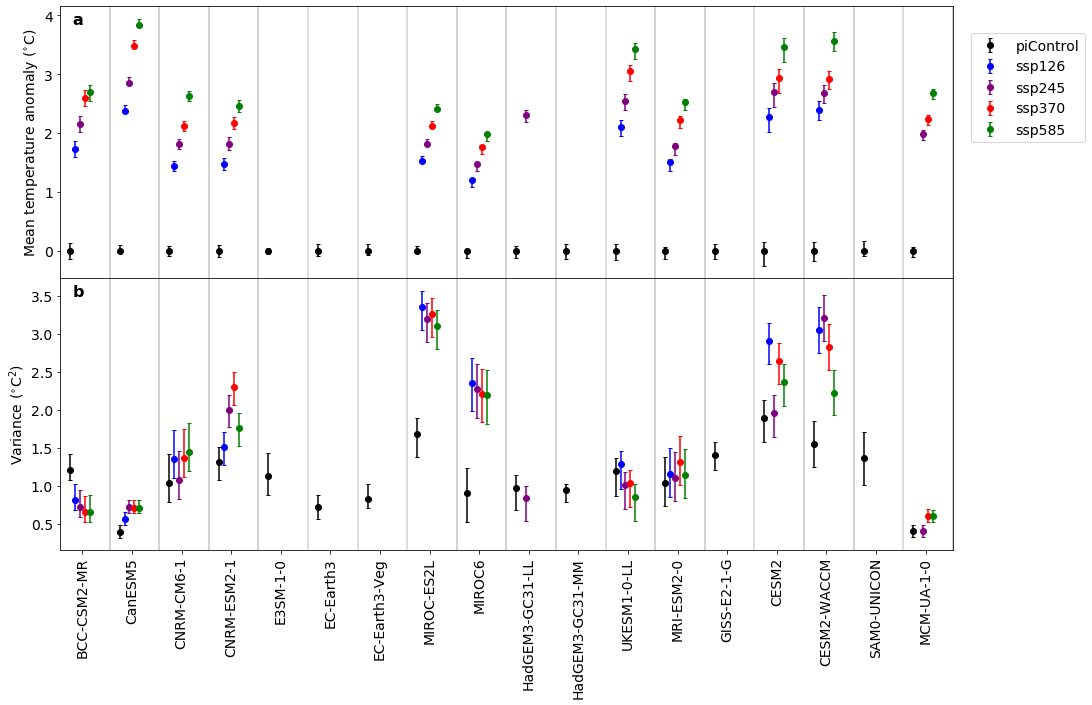

In [10]:
# create figure:
fig, ax = plt.subplots(nrows = 2, figsize = [16,10])
chosen_member_list = []

for (k,model) in enumerate(models):
    file = model + '_DJF_nino3_4index.txt'
    data_table = pd.read_csv(datapath + file,index_col=0, header=[0,1], keep_default_na = False)
    members = {}
    for exp in experiments:
        members[exp] = 0
        if exp in data_table:
            plot_member = choose_member(data_table, exp, model)
            chosen_member_list.append([model,plot_member, exp])
            #print(model,plot_member, exp)

            # plot chosen member with error bars
            data_list = data_table[exp][plot_member].values
            # remove empty strings and convert remaining strings to float:
            data = np.array([np.float(i) for i in data_list if i])
            if exp in experiments[-4:]: # if future scenario
                data = data[:ssp_required_length] # stop in year 2100
            if exp == 'piControl':
                control_data = data
                df.loc[model][('piControl', 'length')] = len(control_data) + 1 # to give original length
                df.loc[model][('piControl', 'length of other members')] = ",".join(piControl_lengths)
                # split into segments and compute their mean and variance:
                means, variances = segments(control_data)
                # all error bars are calculated from piControl segments as:
                mean_lerror = control_data.mean() - means.min()
                mean_uerror = means.max() - control_data.mean()
                var_lerror = control_data.var() - variances.min()
                var_uerror = variances.max() - control_data.var()
            if k == 0:
                # define also labels for legend
                anomaly =  data.mean() - control_data.mean();
                ax[0].errorbar(x[exp][k], anomaly, yerr = [[mean_lerror], [mean_uerror]], fmt='o', marker = 'o', color=color_dict[exp], label = exp,  capsize=2)
                members[exp] += 1
                
                # plot also variance of anomalies
                anom = find_anomaly(model,exp, data = data)
                ax[1].errorbar(x[exp][k], anom.var(), yerr = [[var_lerror], [var_uerror]], marker = 'o', color=color_dict[exp], label = exp,  capsize=2)
                ax[0].axvline(x['piControl'][k]+0.8, color='lightgray')
                ax[1].axvline(x['piControl'][k]+0.8, color='lightgray')
            else:
                anomaly =  data.mean() - control_data.mean();
                ax[0].errorbar(x[exp][k], anomaly, yerr = [[mean_lerror], [mean_uerror]], marker = 'o', color=color_dict[exp],  capsize=2)
                members[exp] += 1
                
                # plot also variance of anomalies
                anom = find_anomaly(model,exp, data = data)
                ax[1].errorbar(x[exp][k], anom.var(), yerr = [[var_lerror], [var_uerror]], marker = 'o', color=color_dict[exp],  capsize=2)
                ax[0].axvline(x['piControl'][k]+0.8, color='lightgray')
                ax[1].axvline(x['piControl'][k]+0.8, color='lightgray')
        # save number of members in dataframe
        if exp in experiments[1:]:
            df.loc[model][(exp, 'members')] = members[exp]
    

for axis in ax:
    axis.tick_params(axis='both',labelsize=14)
    axis.set_xlim(0.8, 18.8)
ax[0].set_ylabel('Mean temperature anomaly ($^{\circ}$C)', fontsize = 14)
ax[0].set_xticklabels([])
ax[0].legend(loc=(1.02,0.5), fontsize = 14);

ax[1].tick_params(axis='both',labelsize=14)    
ax[1].set_ylabel('Variance ($^{\circ}$C$^2$)', fontsize = 14)
#ax[1].legend(loc=(1.02,0.5), fontsize = 14);

plt.xticks(x['piControl']+0.25, models, rotation=90);
plt.subplots_adjust(hspace=0)

plt.text(0.02, 0.95, 'a', fontweight = 'bold', fontsize = 16, horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes);
plt.text(0.02, 0.95, 'b', fontweight = 'bold', fontsize = 16, horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes);

#plt.savefig('../Figures/Figure1.png', format='png', dpi=300, bbox_inches="tight")

In [11]:
chosen_member_list

[['BCC-CSM2-MR', 'r1i1p1f1', 'piControl'],
 ['BCC-CSM2-MR', 'r1i1p1f1', 'ssp126'],
 ['BCC-CSM2-MR', 'r1i1p1f1', 'ssp245'],
 ['BCC-CSM2-MR', 'r1i1p1f1', 'ssp370'],
 ['BCC-CSM2-MR', 'r1i1p1f1', 'ssp585'],
 ['CanESM5', 'r1i1p1f1', 'piControl'],
 ['CanESM5', 'r1i1p1f1', 'ssp126'],
 ['CanESM5', 'r1i1p1f1', 'ssp245'],
 ['CanESM5', 'r1i1p1f1', 'ssp370'],
 ['CanESM5', 'r1i1p1f1', 'ssp585'],
 ['CNRM-CM6-1', 'r1i1p1f2', 'piControl'],
 ['CNRM-CM6-1', 'r1i1p1f2', 'ssp126'],
 ['CNRM-CM6-1', 'r1i1p1f2', 'ssp245'],
 ['CNRM-CM6-1', 'r1i1p1f2', 'ssp370'],
 ['CNRM-CM6-1', 'r1i1p1f2', 'ssp585'],
 ['CNRM-ESM2-1', 'r1i1p1f2', 'piControl'],
 ['CNRM-ESM2-1', 'r2i1p1f2', 'ssp126'],
 ['CNRM-ESM2-1', 'r2i1p1f2', 'ssp245'],
 ['CNRM-ESM2-1', 'r2i1p1f2', 'ssp370'],
 ['CNRM-ESM2-1', 'r2i1p1f2', 'ssp585'],
 ['E3SM-1-0', 'r1i1p1f1', 'piControl'],
 ['EC-Earth3', 'r1i1p1f1', 'piControl'],
 ['EC-Earth3-Veg', 'r1i1p1f1', 'piControl'],
 ['MIROC-ES2L', 'r1i1p1f2', 'piControl'],
 ['MIROC-ES2L', 'r1i1p1f2', 'ssp126'],
 ['MIR

## Table of what data are used in this figure:

In [12]:
#df.columns = pd.MultiIndex.from_tuples(df.columns, names=['Experiment','Model'])
df

,"(piControl, length)","(piControl, length of other members)","(historical, members)","(ssp126, members)","(ssp245, members)","(ssp370, members)","(ssp585, members)"
BCC-CSM2-MR,600,,NaN,1,1,1,1
CanESM5,1000,,NaN,1,1,1,1
CNRM-CM6-1,500,,NaN,1,1,1,1
CNRM-ESM2-1,500,,NaN,1,1,1,1
E3SM-1-0,500,,NaN,0,0,0,0
EC-Earth3,501,,NaN,0,0,0,0
EC-Earth3-Veg,500,,NaN,0,0,0,0
MIROC-ES2L,500,,NaN,1,1,1,1
MIROC6,800,,NaN,1,1,1,1
HadGEM3-GC31-LL,500,,NaN,0,1,0,0


## Convert dataframe to latex format:

In [13]:
# drop column of other piControl lengths, and put it in manually in parentheses later
new_cols = cols[:]
new_cols.remove(('piControl' ,'length of other members'))
new_cols

[('piControl', 'length'),
 ('historical', 'members'),
 ('ssp126', 'members'),
 ('ssp245', 'members'),
 ('ssp370', 'members'),
 ('ssp585', 'members')]

In [14]:
df.loc[:,new_cols].to_latex()
# to be copied into a latex document

'\\begin{tabular}{lllllll}\n\\toprule\n{} & (piControl, length) & (historical, members) & (ssp126, members) & (ssp245, members) & (ssp370, members) & (ssp585, members) \\\\\n\\midrule\nBCC-CSM2-MR     &                 600 &                   NaN &                 1 &                 1 &                 1 &                 1 \\\\\nCanESM5         &                1000 &                   NaN &                 1 &                 1 &                 1 &                 1 \\\\\nCNRM-CM6-1      &                 500 &                   NaN &                 1 &                 1 &                 1 &                 1 \\\\\nCNRM-ESM2-1     &                 500 &                   NaN &                 1 &                 1 &                 1 &                 1 \\\\\nE3SM-1-0        &                 500 &                   NaN &                 0 &                 0 &                 0 &                 0 \\\\\nEC-Earth3       &                 501 &                   NaN &            